# Excel Files 

In [22]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import zipfile
import tempfile
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from PIL import Image

c:\Users\larar\anaconda3\envs\deeplearning2024\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


In [11]:
patches = pd.read_excel("Excel Files\HP_WSI-CoordAnnotatedPatches.xlsx")
diagnosis = pd.read_csv("Excel Files\PatientDiagnosis.csv")

In [4]:
diagnosis

,CODI,DENSITAT
0,B22-01,BAIXA
1,B22-02,BAIXA
2,B22-03,NEGATIVA
3,B22-04,NEGATIVA
4,B22-05,NEGATIVA
...,...,...
304,B22-311,ALTA
305,B22-312,ALTA
306,B22-313,ALTA
307,B22-314,NEGATIVA


In [5]:
patches

,Pat_ID,Section_ID,Window_ID,i,j,h,w,Presence
0,B22-129,0,659,7477,11978,256,256,-1
1,B22-68,0,131,6597,12009,256,256,-1
2,B22-68,0,141,5100,10737,256,256,-1
3,B22-68,0,290,5015,14908,256,256,-1
4,B22-68,0,298,11626,13928,256,256,-1
...,...,...,...,...,...,...,...,...
1210,B22-109,0,320,19818,17909,256,256,-1
1211,B22-109,0,322,19565,18002,256,256,-1
1212,B22-109,0,323,19457,18177,256,256,-1
1213,B22-125,0,3028,23888,19096,256,256,-1


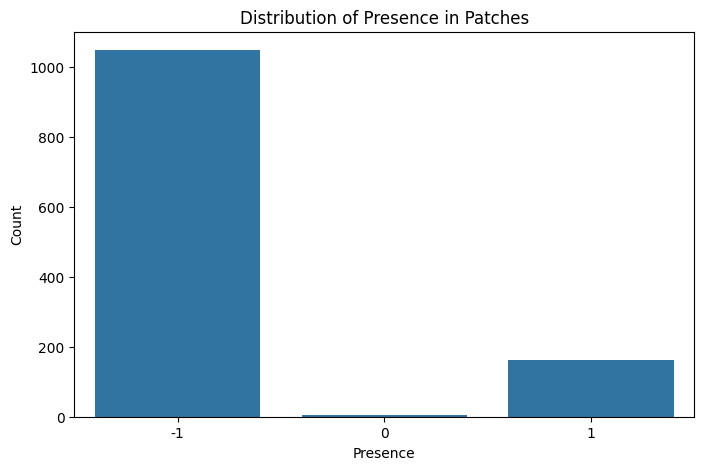

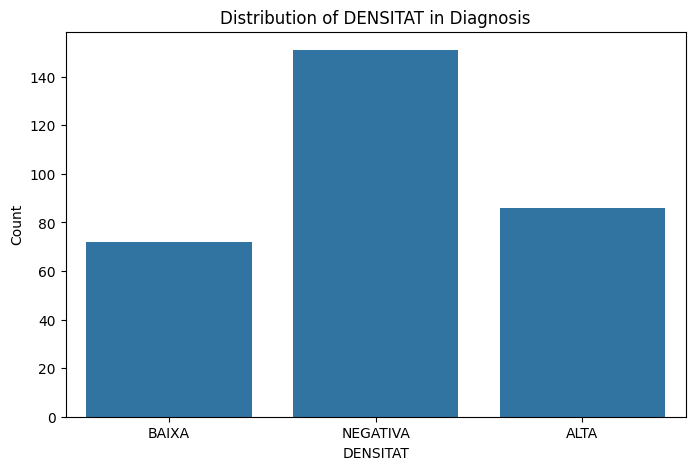

In [10]:
# Load your data
patches = pd.read_excel("Excel Files/HP_WSI-CoordAnnotatedPatches.xlsx")
diagnosis = pd.read_csv("Excel Files/PatientDiagnosis.csv")

# 1. Bar Plot of `Presence` distribution in patches
plt.figure(figsize=(8, 5))
sns.countplot(data=patches, x='Presence')
plt.title('Distribution of Presence in Patches')
plt.xlabel('Presence')
plt.ylabel('Count')
plt.show()

# 2. Bar Plot of `DENSITAT` distribution in diagnosis
plt.figure(figsize=(8, 5))
sns.countplot(data=diagnosis, x='DENSITAT')
plt.title('Distribution of DENSITAT in Diagnosis')
plt.xlabel('DENSITAT')
plt.ylabel('Count')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


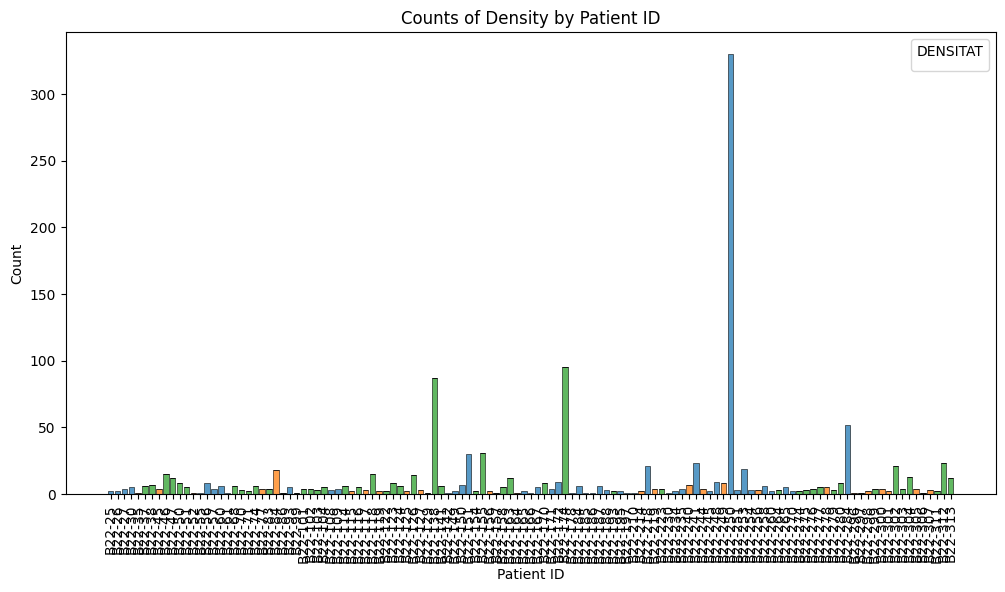

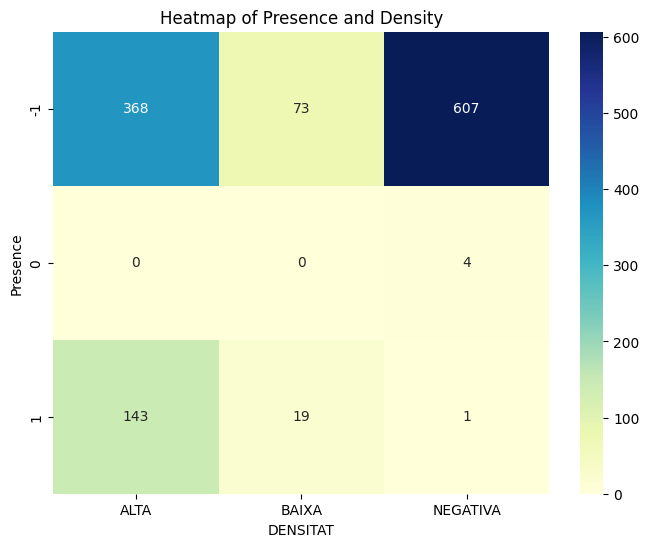

In [12]:
# Merge datasets on common patient ID columns
merged_df = pd.merge(diagnosis, patches, left_on='CODI', right_on='Pat_ID', suffixes=('_diagnosis', '_patches'))

# Counts of Density by Patient ID for each Presence value
plt.figure(figsize=(12, 6))
sns.histplot(data=merged_df, x='Pat_ID', hue='DENSITAT', multiple='stack', shrink=0.8)
plt.title('Counts of Density by Patient ID')
plt.xlabel('Patient ID')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='DENSITAT')
plt.show()

# Heatmap of Presence and Density
density_presence_ct = pd.crosstab(merged_df['Presence'], merged_df['DENSITAT'])
plt.figure(figsize=(8, 6))
sns.heatmap(density_presence_ct, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Heatmap of Presence and Density')
plt.xlabel('DENSITAT')
plt.ylabel('Presence')
plt.show()

Tenemos la ubicacion de todas las patches del zip que tambien estan en el CSV_pathces, con su label

In [7]:
import shutil
#folder_new = r"C:/Users/migue\OneDrive\Escritorio\UAB INTELIGENCIA ARTIFICIAL\Tercer Any\3A\Vision and Learning\Challenge 2\ANNOTATED(CSV)" 
#temp_dir = r"C:/Users/migue\OneDrive\Escritorio\UAB INTELIGENCIA ARTIFICIAL\Tercer Any\3A\Vision and Learning\Challenge 2\ANNOTATED(CSV)" 
temp_dir = r"C:/Users\larar\OneDrive\Documentos\Escritorio\CHALLENGE#2_VISION\EXTRACT"
folder_new = r"C:\Users\larar\OneDrive\Documentos\Escritorio\CHALLENGE#2_VISION\EXTRACT"
# Define a general directory to move all images to
general_dir = os.path.join(folder_new)
os.makedirs(general_dir, exist_ok=True)

# Iterate over each folder and image
for folder_name in os.listdir(temp_dir):
    full_folder_path = os.path.join(temp_dir, folder_name)
    
    for patient in os.listdir(full_folder_path):
        patient_folder = os.path.join(full_folder_path, patient)
        
        # Process each image in the patient folder
        for img_file in os.listdir(patient_folder):
            img_name, ext = os.path.splitext(img_file)
            pat_id = patient.rsplit('_', 1)[0]
            key = f"{pat_id}_{img_name}"
            
            new_img_name = f"{key}{ext}"
            new_img_path = os.path.join(general_dir, new_img_name)
                
            # Move image to the general folder with new name
            shutil.move(os.path.join(patient_folder, img_file), new_img_path)
        
        # Delete the folder if empty
        if not os.listdir(patient_folder):
            os.rmdir(patient_folder)
    
    # Delete the main folder if empty
    if not os.listdir(full_folder_path):
        os.rmdir(full_folder_path)

print("All images moved, folders cleaned up.")


All images moved, folders cleaned up.


In [9]:
# Inicializar contador de archivos
file_count = 0

# Recorrer todas las carpetas y subcarpetas
for file in os.listdir(folder_new):
    full_folder_path = os.path.join(folder_new, file)

    if not full_folder_path.endswith("png"):
        os.rmdir(full_folder_path)
    else:
        file_count += 1

print(f"Total de archivos (imágenes) encontrados: {file_count}")


NotADirectoryError: [WinError 267] El nombre del directorio no es válido: 'C:\\Users\\larar\\OneDrive\\Documentos\\Escritorio\\CHALLENGE#2_VISION\\EXTRACT\\B22-101_Thumbs.db'

In [21]:
labels_dict = {}

for idx, row in patches.iterrows():
    pat_id = row['Pat_ID']
    window_id = f"{int(row['Window_ID']):05d}"  #add 0 until 5
    presence = row['Presence']
    key = f"{pat_id}_{window_id}"
    labels_dict[key] = presence

class CustomDataset(Dataset):
    def __init__(self, root_dir, labels_dict, transform=None):
        self.root_dir = root_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for img_file in os.listdir(root_dir):
            key, _ = os.path.splitext(img_file)  
            if key in labels_dict:
                img_path = os.path.join(root_dir, img_file)
                self.image_paths.append(img_path)
                self.labels.append(1 if labels_dict[key] > 0 else 0)  #labels
            else:
                print(f"{key} not found in CSV")

        print(f"Number of Images that appear both in CSV and zip: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
#NOT IMPORTANT
temp_dir = folder_new

# Crear transformaciones de imagen
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
        
# Instanciar dataset y dataloader
dataset = CustomDataset(root_dir=temp_dir, labels_dict=labels_dict, transform=transform)

B22-101_00201_Aug1 not found in CSV
B22-101_00201_Aug2 not found in CSV
B22-101_00201_Aug3 not found in CSV
B22-101_00201_Aug4 not found in CSV
B22-101_00201_Aug5 not found in CSV
B22-101_00201_Aug6 not found in CSV
B22-101_00201_Aug7 not found in CSV
B22-101_00201_Aug8 not found in CSV
B22-101_Thumbs not found in CSV
B22-102_01468_Aug1 not found in CSV
B22-102_01468_Aug2 not found in CSV
B22-102_01468_Aug3 not found in CSV
B22-102_01468_Aug4 not found in CSV
B22-102_01468_Aug5 not found in CSV
B22-102_01468_Aug6 not found in CSV
B22-102_01468_Aug7 not found in CSV
B22-102_01468_Aug8 not found in CSV
B22-102_03685_Aug1 not found in CSV
B22-102_03685_Aug2 not found in CSV
B22-102_03685_Aug3 not found in CSV
B22-102_03685_Aug4 not found in CSV
B22-102_03685_Aug5 not found in CSV
B22-102_03685_Aug6 not found in CSV
B22-102_03685_Aug7 not found in CSV
B22-102_03685_Aug8 not found in CSV
B22-102_Thumbs not found in CSV
B22-103_02201_Aug1 not found in CSV
B22-103_02201_Aug2 not found in CSV
